In [73]:
import gc, os
import pickle
import cfgrib
import pygrib

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from glob import glob
from functools import reduce
from datetime import datetime
from sklearn.preprocessing import RobustScaler

os.environ['OMP_NUM_THREADS'] = '1'
mp_use_cores = 32
use_era_scaler = False

In [74]:
model = 'gfs0p25'
archive = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/archive/'
mlmodel_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/output/slr_models/all_dev/'

In [75]:
init = datetime(2020, 1, 1, 0, 0)
date_fmt = '%Y%m%d'
datetime_fmt = '%Y%m%d%H'

## Data Ingest

In [76]:
def ingest_gfs(f):
    
    # print('Reading %s'%os.path.basename(f))

    datasets = cfgrib.open_datasets(f)

    keep_keys = ['tp', 'q', 't', 'u', 'v', 'absv', 'w', 'gh', 'r', 'd', 
                  'u10', 'v10', 'u100', 'v100', 't2m', 'd2m', 
                  'cape', 'prmsl', 'sp', 'orog', 'hpbl']

    sfc, iso = [], []

    for ds in datasets:

        key_match = np.array(list(ds.data_vars))[np.isin(list(ds.data_vars), keep_keys)]

        if len(key_match) > 0:

            dims = ds.dims.keys()
            coords = ds[key_match].coords

            if ('heightAboveGround' in coords) & ('heightAboveGround' not in dims):
                sfc.append(ds[key_match].drop('heightAboveGround'))

            elif 'isobaricInhPa' in coords:
                iso.append(ds[key_match])

            elif (('surface' in coords)|('meanSea' in coords)):
                sfc.append(ds[key_match])

            elif 'prmsl' in list(ds.data_vars):
                sfc.append(ds['prmsl'])

            else:
                pass

        else:
            pass
            #print(list(ds.data_vars))

    sfc = xr.merge(sfc).drop('t')
    iso = xr.merge(iso).rename({'isobaricInhPa':'level'})
    iso = iso.sel(level=iso.level[::-1])

    sfc['longitude'] = sfc['longitude'] - 360
    iso['longitude'] = iso['longitude'] - 360
    
    iso_all.append(iso.drop('step'))
    sfc_all.append(sfc.drop(['surface', 'meanSea', 'step']))
    
    return [sfc, iso]

In [77]:
flist = glob(archive + init.strftime(date_fmt) + '/models/%s/*%s*.grib2'%(model, init.strftime(datetime_fmt)))[1:]

with get_context('fork').Pool(mp_use_cores) as p:
    returns = p.map(ingest_gfs, flist, chunksize=1)
    p.close()
    p.join()
    
returns = np.array(returns, dtype=object)
sfc, iso = returns[:, 0], returns[:, 1]
    
iso = xr.concat(iso, dim='valid_time').drop('time').rename({'valid_time':'time'}).sortby('time')
sfc = xr.concat(sfc, dim='valid_time').drop('time').rename({'valid_time':'time'}).sortby('time')

In [78]:
u, v = iso['u'], iso['v']
wdir = 90 - np.degrees(np.arctan2(-v, -u))
wdir = xr.where(wdir <= 0, wdir+360, wdir)
wdir = xr.where(((u == 0) & (v == 0)), 0, wdir)

iso['dir'] = wdir
iso['spd'] = np.sqrt(u**2 + v**2)

for hgt in [10, 100]:
    
    u, v = sfc['u%d'%hgt], sfc['v%d'%hgt]
    wdir = 90 - np.degrees(np.arctan2(-v, -u))
    wdir = xr.where(wdir <= 0, wdir+360, wdir)
    wdir = xr.where(((u == 0) & (v == 0)), 0, wdir)
    
    sfc['dir%dm'%hgt] = wdir
    sfc['spd%dm'%hgt] = np.sqrt(u**2 + v**2)

In [79]:
# sfc['day_of_year'] = (('latitude', 'longitude'), 
#                       np.full(sfc.orog.shape, 
#                               fill_value=pd.to_datetime(
#                                   sfc.time.values).strftime('%j')).astype(int))
# sfc

## Transform to levels above ground

In [80]:
orog = sfc.orog
gh = iso.gh

lowest_level = np.full(orog.shape, fill_value=np.nan)
lowest_level_index = np.full(orog.shape, fill_value=np.nan)

for i, level in enumerate(iso['level']):
    
    lev_gh = gh.sel(level=level)
    lowest_level = xr.where(orog >= lev_gh, level.values, lowest_level)
    lowest_level_index = xr.where(orog >= lev_gh, i, lowest_level_index)
    
lowest_level_index = xr.where(np.isnan(lowest_level), 0, lowest_level_index)
lowest_level = xr.where(np.isnan(lowest_level), 1000, lowest_level)

In [81]:
df = []
match_rename = {'absv':'vo', 'gh':'z', 'hpbl':'blh', 'prmsl':'msl', 'tp':'swe_mm',
               'u10':'u10m', 'v10':'v10m', 'u100':'u100m', 'v100':'v100m'}

# Loop over each variable in the xarray
for ds in [iso, sfc.drop('orog')]:
    
    for var_name in ds.data_vars:
        
        new_var_name = match_rename[var_name] if var_name in match_rename.keys() else var_name
        print('Reducing (%s) to %s index level AGL'%(var_name, new_var_name))

        var = ds[var_name]

        if 'level' in var.coords:

            for i in np.arange(10):

                var_agl = np.full(shape=(orog.shape), fill_value=np.nan)

                for j, level in enumerate(iso['level']):

                    var_agl = xr.where(lowest_level_index+i == j, var.isel(level=j), var_agl)

                    # Record the levels used, should match lowest_level array, sanity check
                    # var_agl[i, :, :] = xr.where(lowest_level_index+i == j, level, var_agl[i, :, :])

                # We could ho ahead and append to the pandas dataframe here 
                # at the completion of each level (_01agl, _02agl...)
                # We will have to use [(time), lat, lon] as a multiindex
                var_agl = xr.DataArray(var_agl, 
                     dims=['time', 'latitude', 'longitude'], 
                     coords={'time':ds['time'],
                             'latitude':ds['latitude'], 
                             'longitude':ds['longitude']})

                df.append(var_agl.to_dataframe(name='%s_%02dagl'%(new_var_name.upper(), i+1)))

                del var_agl
                gc.collect()

        else:

            var_agl = xr.DataArray(var.values, 
                dims=['time', 'latitude', 'longitude'], 
                coords={'time':ds['time'],
                    'latitude':ds['latitude'], 
                     'longitude':ds['longitude']})

            df.append(var_agl.to_dataframe(name='%s'%new_var_name.upper()))

# SLOW!!! Is there anything we can do here??
df = reduce(lambda left, right: pd.merge(left, right, on=['time', 'latitude', 'longitude']), df)
df = df.rename(columns={'SWE_MM':'swe_mm'})

Reducing (t) to t index level AGL
Reducing (gh) to z index level AGL
Reducing (u) to u index level AGL
Reducing (v) to v index level AGL
Reducing (r) to r index level AGL
Reducing (w) to w index level AGL
Reducing (absv) to vo index level AGL
Reducing (dir) to dir index level AGL
Reducing (spd) to spd index level AGL
Reducing (u10) to u10m index level AGL
Reducing (v10) to v10m index level AGL
Reducing (t2m) to t2m index level AGL
Reducing (d2m) to d2m index level AGL
Reducing (u100) to u100m index level AGL
Reducing (v100) to v100m index level AGL
Reducing (prmsl) to msl index level AGL
Reducing (cape) to cape index level AGL
Reducing (sp) to sp index level AGL
Reducing (tp) to swe_mm index level AGL
Reducing (hpbl) to blh index level AGL
Reducing (dir10m) to dir10m index level AGL
Reducing (spd10m) to spd10m index level AGL
Reducing (dir100m) to dir100m index level AGL
Reducing (spd100m) to spd100m index level AGL


In [82]:
scaler_file = glob(mlmodel_dir + '*scaler*')[-1]
stats_file = glob(mlmodel_dir + '*train_stats*')[-1]
model_file = glob(mlmodel_dir + '*SLRmodel*')[-1]

if use_era_scaler == True:
    with open(scaler_file, 'rb') as rfp:
        scaler = pickle.load(rfp)
else:
    scaler = RobustScaler(quantile_range=(25, 75))

with open(stats_file, 'rb') as rfp:
    train_stats, train_stats_norm = pickle.load(rfp)
    model_keys = train_stats.keys()
    
with open(model_file, 'rb') as rfp:
    SLRmodel = pickle.load(rfp)

In [83]:
print('\ncheck: missing from model', [k for k in df.keys() if k not in model_keys])
print('\ncheck: missing from input', [k for k in model_keys if k not in df.keys()])
print()

df = df.loc[:, model_keys]
scaler = scaler.fit(df)


check: missing from model []

check: missing from input []



In [84]:
df_norm = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.keys())
df_norm

swe_mm   T_01agl   U_01agl   V_01agl  \
time                latitude longitude                                         
2020-01-01 03:00:00 30.0     -130.00    0.0000  0.810550 -1.578271 -1.883023   
                             -129.75    0.0000  0.810550 -1.522281 -1.904771   
                             -129.50    0.0000  0.801828 -1.470022 -1.921082   
                             -129.25    0.0000  0.793110 -1.428962 -1.946455   
                             -129.00    0.0000  0.793110 -1.376704 -2.004450   
...                                        ...       ...       ...       ...   
2020-01-08 12:00:00 50.0     -101.00    2.8750 -0.959301 -1.284737  0.696174   
                             -100.75    3.0000 -1.072674 -1.490037  0.551186   
                             -100.50    3.0625 -1.168606 -1.602018  0.442445   
                             -100.25    3.0000 -1.220932 -1.639346  0.388074   
                             -100.00    3.0625 -1.238375 -1.564691  0.315580   

                                        VO_01agl   W_01agl   Z_01agl  \
time                latitude longitude                                 
2020-01-01 03:00:00 30.0     -130.00   -0.156490 -0.161989 -0.521525   
                             -129.75   -0.116318 -0.138513 -0.523108   
                             -129.50   -0.102928 -0.190159 -0.524818   
                             -129.25   -0.129709 -0.063393 -0.526444   
                             -129.00   -0.116318 -0.039917 -0.527673   
...                                          ...       ...       ...   
2020-01-08 12:00:00 50.0     -101.00    1.205198 -0.706215 -0.360181   
                             -100.75    1.017729 -0.443291 -0.356054   
                             -100.50    1.031120 -0.602923 -0.351983   
                             -100.25    0.857041 -0.391646 -0.348605   
                             -100.00    0.522274 -0.748470 -0.345242   

                                         R_01agl  SPD_01agl  DIR_01agl  ...  \
time                latitude longitude                                  ...   
2020-01-01 03:00:00 30.0     -130.00    0.088398   1.180398  -1.512315  ...   
                             -129.75    0.118785   1.172742  -1.522722  ...   
                             -129.50    0.146409   1.163797  -1.532157  ...   
                             -129.25    0.162983   1.166655  -1.540690  ...   
                             -129.00    0.168508   1.190551  -1.553535  ...   
...                                          ...        ...        ...  ...   
2020-01-08 12:00:00 50.0     -101.00    0.798343   0.191396  -0.846830  ...   
                             -100.75    0.784530   0.280408  -0.925948  ...   
                             -100.50    0.773481   0.335135  -0.971952  ...   
                             -100.25    0.767956   0.352453  -0.991760  ...   
                             -100.00    0.770718   0.281005  -1.009902  ...   

                                             MSL        SP      U10M  \
time                latitude longitude                                 
2020-01-01 03:00:00 30.0     -130.00    0.286250  0.704357 -1.533032   
                             -129.75    0.274667  0.703124 -1.475959   
                             -129.50    0.263224  0.701701 -1.427667   
                             -129.25    0.251914  0.700467 -1.388156   
                             -129.00    0.240332  0.699424 -1.335473   
...                                          ...       ...       ...   
2020-01-08 12:00:00 50.0     -101.00   -1.937280  0.211109 -1.377313   
                             -100.75   -1.888062  0.218320 -1.596822   
                             -100.50   -1.838671  0.221736 -1.684625   
                             -100.25   -1.788941  0.222210 -1.728527   
                             -100.00   -1.738865  0.224961 -1.662674   

                                            V10M     U100M     V100M  \
time                latit

In [85]:
# We're going to need to bin these out and process in parallel
# By time is likely easiest

slr = pd.DataFrame(SLRmodel.predict(df_norm), 
                   index=df_norm.index, columns=['slr']
                  ).to_xarray()['slr']

slr = xr.where(slr < 0, 0, slr)

slr

<xarray.DataArray 'slr' (time: 60, latitude: 81, longitude: 121)>
array([[[ 8.28770276,  8.42279155,  8.00302213, ..., 14.72449127,
         15.50964384, 16.14684845],
        [ 8.43616441,  8.29855722,  8.53817409, ..., 14.08328295,
         14.96236374, 14.83461924],
        [ 8.92802583,  8.43319554,  7.60377441, ..., 14.24386008,
         14.91289259, 15.32781711],
        ...,
        [11.24500451, 11.24500451, 11.24500441, ..., 16.97277704,
         16.3312098 , 16.30035959],
        [11.24453289, 11.23158165, 11.20412104, ..., 16.5807863 ,
         16.0513452 , 15.66111636],
        [10.02474065, 10.43667718, 10.04586395, ..., 18.12131462,
         17.0611938 , 16.27579349]],

       [[ 6.75367372,  7.51327386,  8.60577874, ..., 14.47492651,
         14.24146489, 14.81519338],
        [ 7.45254397,  6.93350242,  6.60573442, ..., 15.10752942,
         15.02692191, 14.49613874],
        [ 9.39845247,  8.99100696,  8.20363265, ..., 17.07336333,
         16.35505207, 16.03618648],
...
        [11.24500451, 11.24500451, 11.24500451, ..., 14.67632375,
         16.39918867, 17.08639397],
        [11.24500451, 11.24500451, 11.24500451, ..., 17.20187702,
         17.56187564, 15.8973307 ],
        [11.24500451, 11.24500451, 11.24500451, ..., 15.45021228,
         14.9879832 , 14.20380362]],

       [[ 9.97241571,  8.9285921 , 10.16901626, ..., 15.98124791,
         16.45612812, 16.39526049],
        [11.80136971, 11.91258551, 11.32859453, ..., 16.74411222,
         14.25049308, 15.72002909],
        [12.52975064, 11.59549771, 11.07452389, ..., 16.60985064,
         15.47576299, 15.95763535],
        ...,
        [11.2450045 , 11.24500451, 11.24500451, ..., 14.35506531,
         13.51711892, 13.87472328],
        [11.24500451, 11.24500451, 11.24500451, ..., 14.17704094,
         13.60654618, 16.54066428],
        [11.24500451, 11.24500451, 11.24500451, ..., 15.0279602 ,
         14.56514793, 14.18504534]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01T03:00:00 ... 2020-01-08T12:00:00
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.5 49.75 50.0
  * longitude  (longitude) float64 -130.0 -129.8 -129.5 ... -100.5 -100.2 -100.0

60


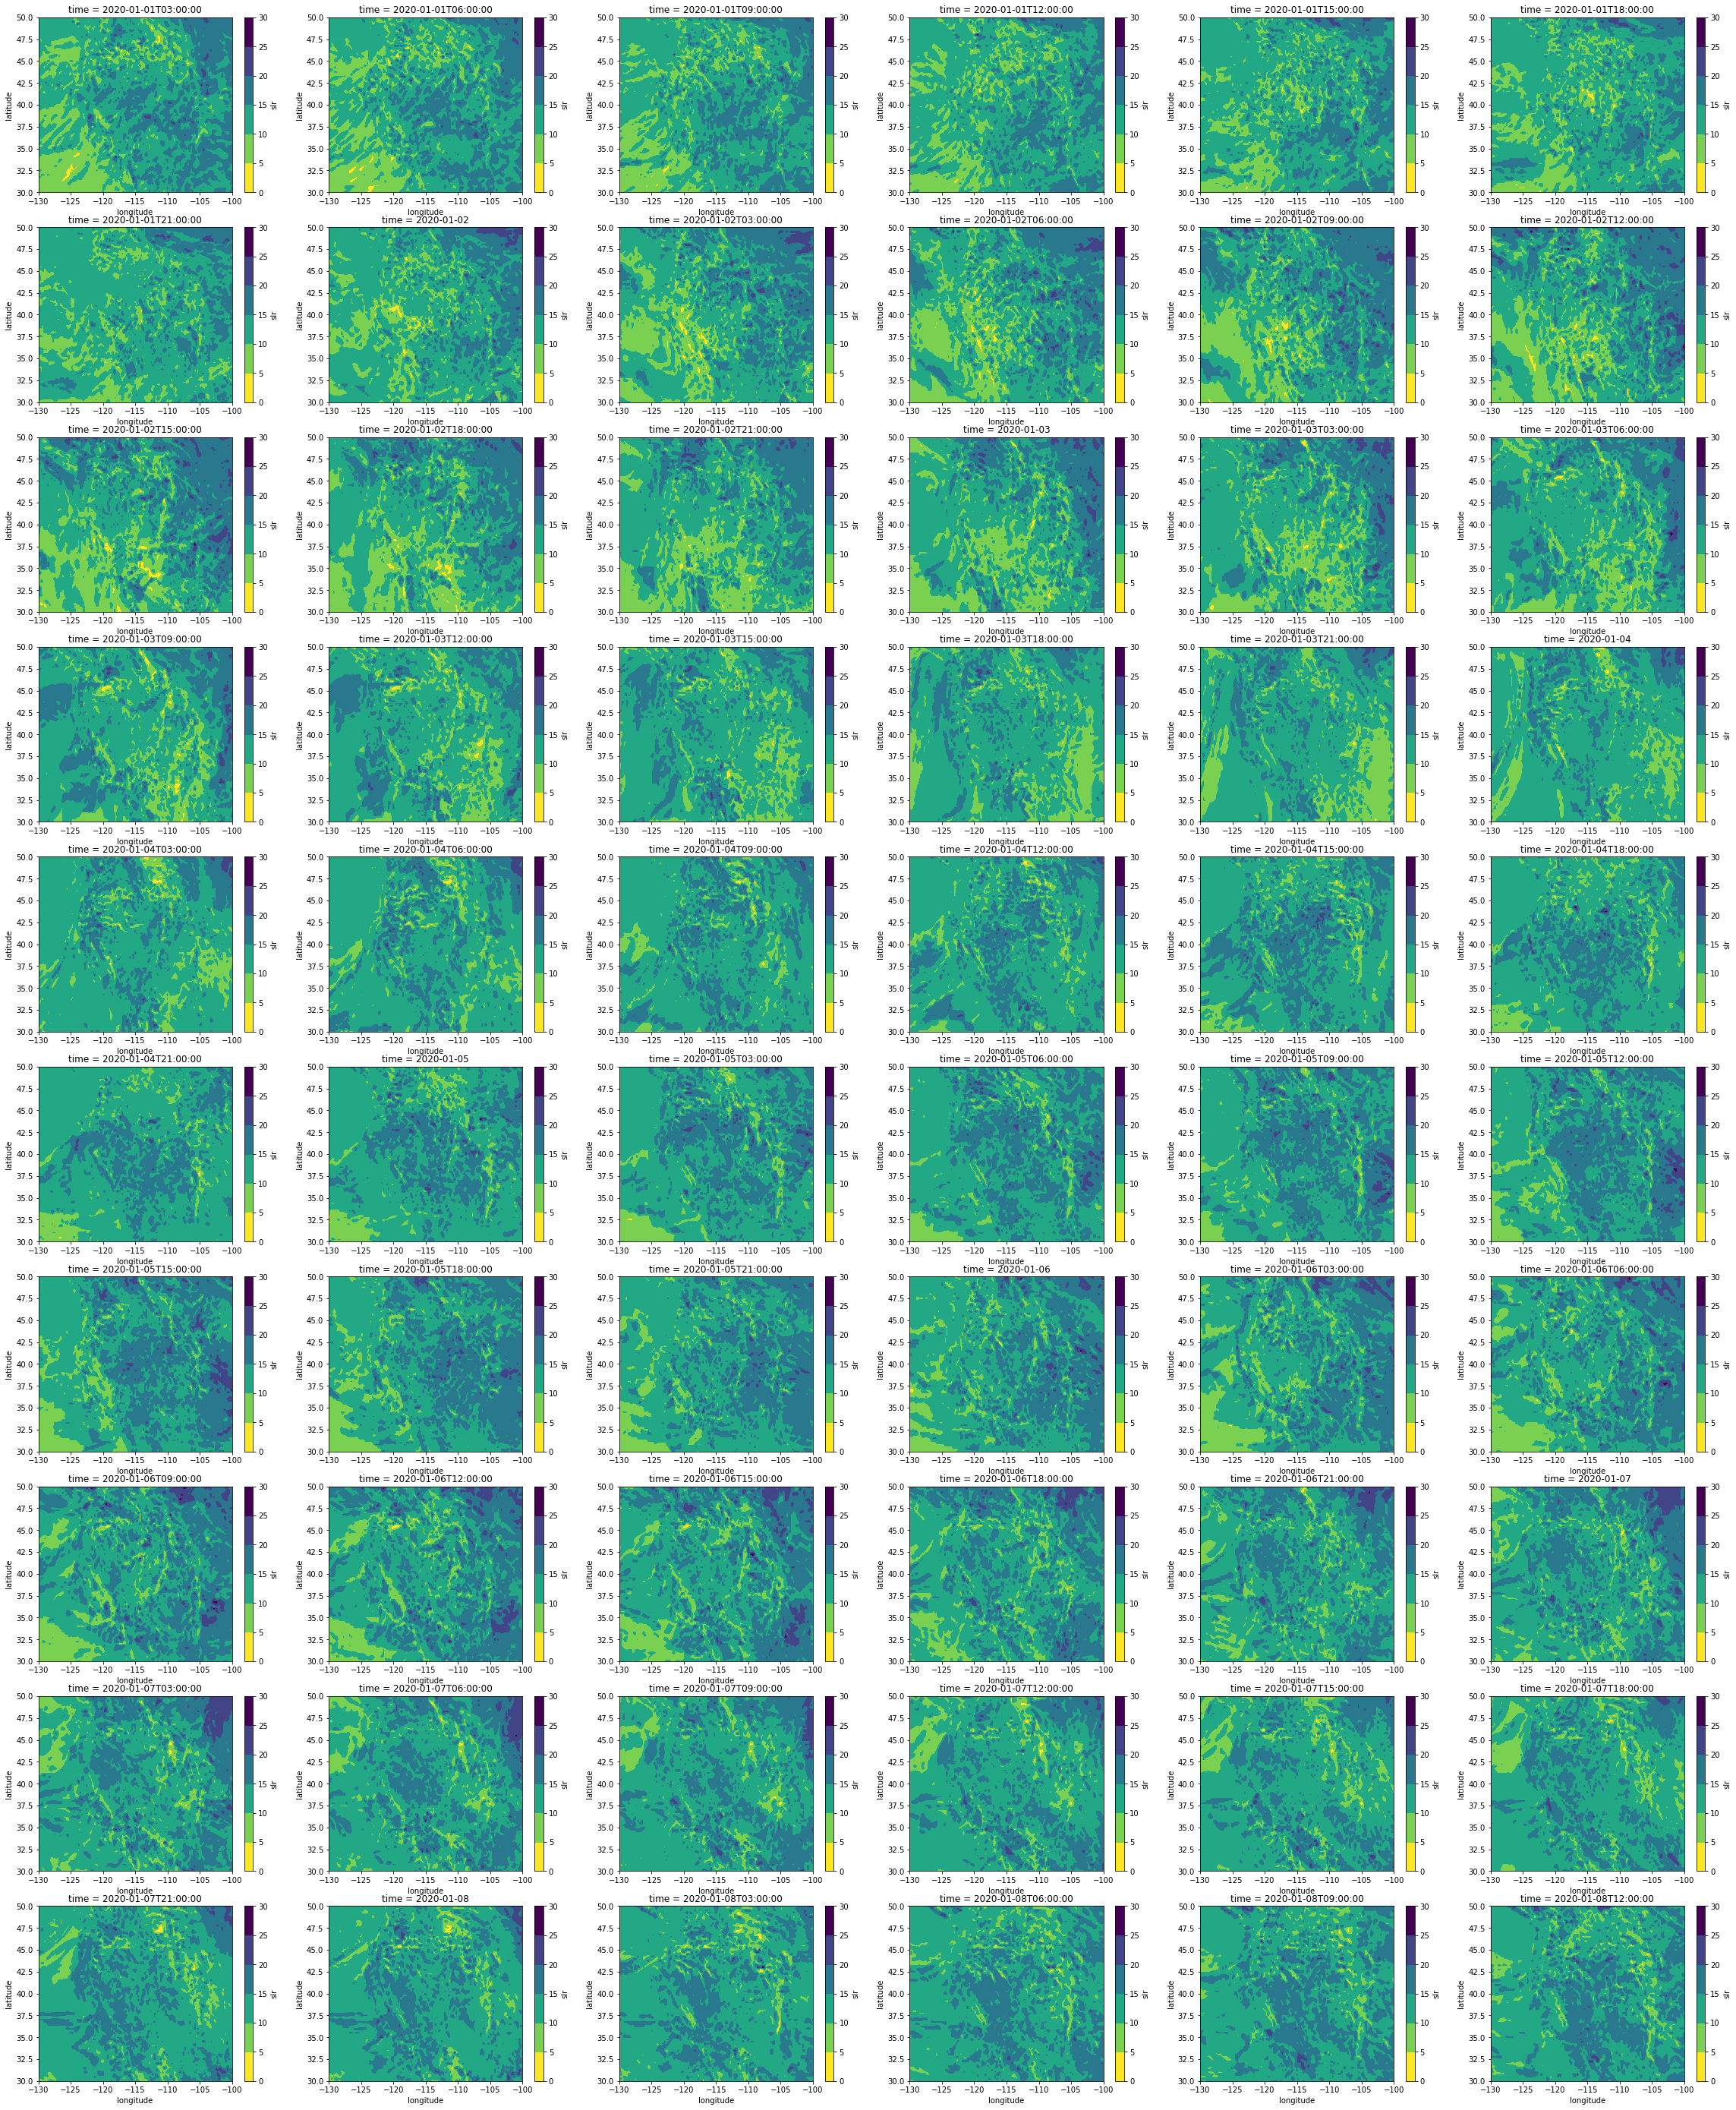

In [103]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(10, 6, figsize=(40, 50))
axs = axs.flatten()

for i, t in enumerate(slr.time):

#     plt.axes(projection=ccrs.PlateCarree())

    slr.sel(time=t).plot.contourf(ax=axs[i], vmin=0, vmax=30, cmap='viridis_r')
    
#     slr.sel(time=t).plot.hist(ax=axs[i])
#     plt.xlim([0, 30])

#     ax.coastlines()

#     states_provinces = cfeature.NaturalEarthFeature(
#             category='cultural',
#             name='admin_1_states_provinces_lines',
#             scale='110m',
#             facecolor='none')

#     ax.add_feature(states_provinces, edgecolor='k')
 
#     plt.title(os.path.basename(flist[1]))

plt.show()